In [1]:
import pvl
import struct
import matplotlib.pyplot as plt
import numpy as np
import datetime
import os.path
import binascii

In [2]:
image_file = '/Users/kelvin/repos/ISIS3/isis/src/odyssey/apps/thm2isis/tsts/case01/input/I00831002RDR.QUB'

In [3]:
header = pvl.load(image_file)

In [4]:
image_offset = header['^SPECTRAL_QUBE'] * header['RECORD_BYTES']
image_offset

12236

In [5]:
with open(image_file, 'rb') as f:
    f.seek(image_offset)
    image_data = f.read()

In [6]:
n_lines = 5
n_bands = header["SPECTRAL_QUBE"]["CORE_ITEMS"][2]
n_samples = header["SPECTRAL_QUBE"]["CORE_ITEMS"][0]

line_length = (header["SPECTRAL_QUBE"]["CORE_ITEMS"][0] * header["SPECTRAL_QUBE"]['CORE_ITEM_BYTES'])
line_length

640

In [7]:
def read_crism_trdr(b_image_data, line_length, n_lines, n_bands):
    image_data = []
    for j in range(n_lines*n_bands):
        image_sample = np.frombuffer(b_image_data[j*line_length:(j+1)*line_length],
                                     dtype=np.uint16, count=-1)
        image_data.append(image_sample)
    return np.array(image_data)

In [8]:
n_bands = header["SPECTRAL_QUBE"]["CORE_ITEMS"][2]

image_data = read_crism_trdr(image_data, line_length, n_lines, n_bands)

cropped_image_data = image_data

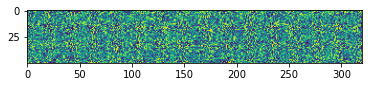

In [9]:
plt.imshow(cropped_image_data)

In [10]:
# Overwrite the number of lines in the label
header["SPECTRAL_QUBE"]["CORE_ITEMS"] = [n_samples, n_lines, n_bands]
header["FILE_RECORDS"] = n_samples * n_lines * n_bands * 2

In [11]:
label_fn, label_ext = os.path.splitext(image_file)
out_label = label_fn + '_cropped' + label_ext

grammar = pvl.grammar.ISISGrammar()
grammar.comments+=(("#", "\n"), )
encoder = pvl.encoder.ISISEncoder()
new_header = pvl.dumps(header, encoder=encoder, grammar=grammar)

In [12]:
with open(out_label, 'wb+') as f:
    b_reduced_image_data = cropped_image_data.tobytes()
    f.write(new_header.encode('utf-8'))
    f.write('\n'.encode('utf-8'))
    f.write(b_reduced_image_data)